In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
#########################
######### DICTIONARIES DEFINITION 
#########################

Range_MLD = {
    'lab' : {
        'vmin' : 20, 
        'vmax' : 2000},
    'gul' : {
        'vmin' : 20, 
        'vmax' : 1000},
    'noe' : {
        'vmin' : 10, 
        'vmax' : 1600},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-15, 10),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [3]:
def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


In [4]:
## Function to crop the dataset

def Crops(coord, d_set):
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))


In [47]:
def Hist_params(data_set, n_bins):
    """
        Hist_param is a function that generates an histogram for each time step
        of a DataArray.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    heigth = np.empty(n_bins)
    
    for i in range(len(data_set.week)):
        d_frame = data_set[i].to_dataframe().dropna(how='all')
        hist, bins = np.histogram(d_frame, bins=n_bins, range=(mn, mx), normed=False)
        heigth = np.vstack((heigth, hist))
        
    h = np.delete(heigth, 0, 0)
    
    return(h)
    

def PDF_time(data_set, mini, maxi, n_bins, *limits):
    """
        PDF_time is a function that generates a 2D plot from histograms
        and time steps. This is the plot will have as 'x' axis values of MLD
        classes in meters, and the 'y' axis will have time dimensions. The 
        colors indicate the number of grid points in each MLD class.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        mini : float
            minimum value to create the 'y' axis
            
        maxi : float
            maximum value to create the 'y' axis
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    x = data_set.week
    y = np.arange(mini, maxi, abs((mini-maxi)/n_bins))
    X, Y = np.meshgrid(x, y)

    hist = Hist_params(data_set, n_bins)
    
    #Minimum and maximum values for the color bar
    vmin = hist.min()
    vmax = hist.max()

    fig, ax = plt.subplots()

    #ax.set_yscale("log", nonposy='clip')
    cs = ax.contourf(X, Y, np.log10(hist.T), 
                     np.linspace(np.log10(1.), np.log10(limits[1]), 11), 
                     cmap='viridis', extend='max')
    
    #cs = ax.contourf(X, Y, hist.T, norm=mpl.colors.LogNorm(), cmap='plasma', snap=True)
    #ax.set_title('Gulf Stream MLD distribution')

    cb = fig.colorbar(cs, ax=ax, orientation='vertical')
    #minorticks = p.norm(np.arange(1, 10, 2))
    #cb.ax.xaxis.set_ticks(minorticks, minor=True)
    
    cb.set_label('log$_{10}$ N')
    #ax.set_clim(10., 4000.)
    
    ##Deberia regresar o no la figura? -> No.
    #H = ax.hist2d(x, y, bins=40, norm=LogNorm())
    #fig.colorbar(H[3], ax=ax)
    
    
def Save_fig(name):
    fig.savefig(name, bbox_inches='tight')
    

def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

# PDF-Time

This is a notebook in which we plot the seasonal cycle of the PDF in a 2D plot.

In [7]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,25])

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason

## Making the histogram for each time stamp

### Gulf stream

In [42]:
coord = 'gul'

gulf1 = Crops(coord, c_armor1)
gulf15 = Crops(coord, c_armor15)

gulf15= Masking(gulf15, gulf15.to[0,25])

In [43]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [ ]:
n_bins = 100
mn = 9.
mx = 250.

clims_g = (0., 2000.)
values = gulf1.groupby('time.week').mean(dim='time')

%matplotlib notebook

plt.close()
#PDF_time(data_set, mini, maxi, n_bins, *limits):
PDF_time(values.mlotst, mn, mx, n_bins, *clims_g)
#plt.yscale('log')
plt.suptitle('Histogram seasonal cycle of the MLD\nGulf Stream', fontsize=14)

plt.xlabel('Months')
plt.ylabel('MLD [m]')

plt.xticks(np.arange(1, values.week.size, step=4.5), months, rotation=20)

plt.grid()
plt.show()
#plt.savefig(dir_o + 'Gul-PDF-Seasonal.png', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


### Labrador and Irminger seas

In [52]:
coord = 'lab'

lab1 = Crops(coord, c_armor1)
lab15 = Crops(coord, c_armor15)

lab15= Masking(lab15, lab15.to[0,25])

In [53]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


<IPython.core.display.Javascript object>


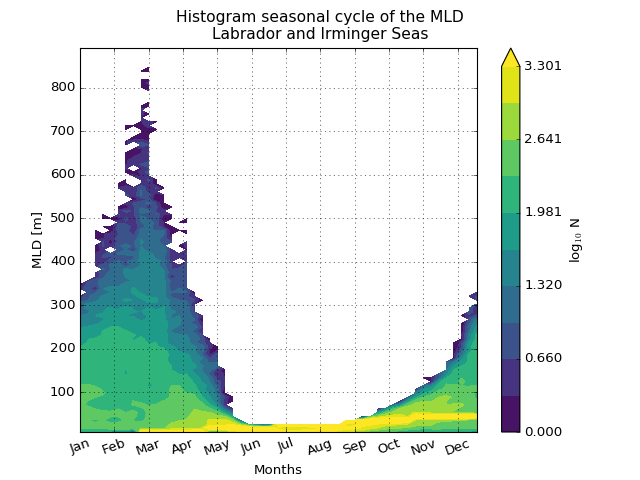

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [54]:
n_bins = 100
mn = 9.
mx = 900.

clims_l = (0., 2000.)
values = lab1.where(lab15.mask==1).groupby('time.week').mean(dim='time')

%matplotlib notebook

plt.close()
#PDF_time(data_set, mini, maxi, n_bins, *limits):
PDF_time(values.mlotst, mn, mx, n_bins, *clims_l)
#plt.yscale('log')
plt.suptitle('Histogram seasonal cycle of the MLD\nLabrador and Irminger Seas', fontsize=14)

plt.xlabel('Months')
plt.ylabel('MLD [m]')

plt.xticks(np.arange(1, values.week.size, step=4.5), months, rotation=20)

plt.grid()
plt.show()
#plt.savefig(dir_o + 'Lab-PDF-Seasonal.png', bbox_inches='tight')

### North East

In [55]:
from matplotlib.colors import LogNorm

coord = 'noe'

noe1 = Crops(coord, c_armor1)
noe15 = Crops(coord, c_armor15)

noe15= Masking(noe15, noe15.to[0,25])

In [56]:
noe1_w = noe1.groupby('time.week').mean(dim='time')

noe1_w.mlotst.where(noe15.mask==1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(498.78571429)

In [57]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


<IPython.core.display.Javascript object>


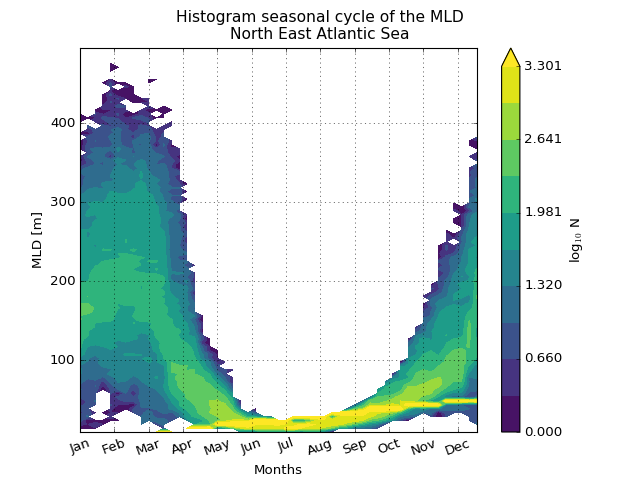

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [58]:
n_bins = 100
mn = 9.
mx = 500.

clims_l = (0., 2000.)
values = noe1.where(noe15.mask==1).groupby('time.week').mean(dim='time')

%matplotlib notebook

plt.close()
#PDF_time(data_set, mini, maxi, n_bins, *limits):
PDF_time(values.mlotst, mn, mx, n_bins, *clims_l)
#plt.yscale('log')
plt.suptitle('Histogram seasonal cycle of the MLD\nNorth East Atlantic Sea', fontsize=14)

plt.xlabel('Months')
plt.ylabel('MLD [m]')

plt.xticks(np.arange(1, values.week.size, step=4.5), months, rotation=20)

plt.grid()
plt.show()
#plt.savefig(dir_o + 'Noe-PDF-Seasonal.png', bbox_inches='tight')

### Nordic Sea

In [59]:
coord = 'nor'

nor1 = Crops(coord, c_armor1)
nor15 = Crops(coord, c_armor15)

nor15= Masking(nor15, nor15.to[0,25])

In [60]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


<IPython.core.display.Javascript object>


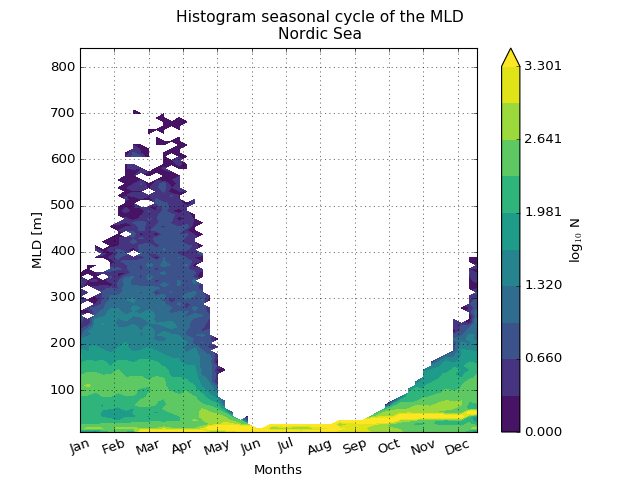

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [61]:
n_bins = 100
mn = 9.
mx = 850.

clims_l = (0., 2000.)
values = nor1.where(nor15.mask==1).groupby('time.week').mean(dim='time')

%matplotlib notebook

plt.close()
#PDF_time(data_set, mini, maxi, n_bins, *limits):
PDF_time(values.mlotst, mn, mx, n_bins, *clims_l)
#plt.yscale('log')
plt.suptitle('Histogram seasonal cycle of the MLD\nNordic Sea', fontsize=14)

plt.xlabel('Months')
plt.ylabel('MLD [m]')

plt.xticks(np.arange(1, values.week.size, step=4.5), months, rotation=20)

plt.grid()
plt.show()
#plt.savefig(dir_o + 'Nor-PDF-Seasonal.png', bbox_inches='tight')